# Results Visualizations
> Ignorance is strength

In [ ]:
# hide
import blackhc.project.script

Appended /home/blackhc/PycharmProjects/bald-ical/src to paths
Switched to directory /home/blackhc/PycharmProjects/bald-ical
%load_ext autoreload
%autoreload 2


In [ ]:
import collections
import functools
import math
import os
import re
from collections import namedtuple
from dataclasses import dataclass
from typing import NamedTuple

import laaos
import pandas as pd
import seaborn as sns

In [ ]:
# https://codereview.stackexchange.com/questions/85311/transform-snake-case-to-camelcase
def camel_case_name(snake_case_name):
    return re.sub("_([a-z])", lambda match: match.group(1).upper(), snake_case_name)


__namedtuples = {}


def to_namedtuple(obj, name):
    type_name = "_" + camel_case_name(name)
    if isinstance(obj, dict):
        keys = tuple(obj.keys())
        if keys in __namedtuples:
            nt = __namedtuples[keys]
        else:
            nt = namedtuple(type_name, keys)
            __namedtuples[keys] = nt
        return nt(*(to_namedtuple(v, k) for k, v in obj.items()))
    if isinstance(obj, list):
        item_type_name = type_name + "Item"
        return [to_namedtuple(item, item_type_name) for item in obj]
    if isinstance(obj, set):
        item_type_name = type_name + "Item"
        return {to_namedtuple(item, item_type_name) for item in obj}
    if isinstance(obj, tuple):
        item_type_name = type_name + "Item"
        return tuple(to_namedtuple(item, item_type_name) for item in obj)

    return obj


def get_any(d: dict):
    return next(iter(d.values()))


def handle_map_funcs(func_kv, func_k, func_v, default=None):
    if func_kv:
        assert func_k is None and func_v is None

        def inner(kv):
            return func_kv(*kv)

    elif func_k:
        assert func_v is None

        def inner(kv):
            return func_k(kv[0]), kv[1]

    elif func_v:

        def inner(kv):
            return kv[0], func_v(kv[1])

    else:
        return default
    return inner


def handle_unary_funcs(pred_kv, pred_k, pred_v, default=None):
    if pred_kv:
        assert pred_k is None and pred_v is None

        def inner(kv):
            return pred_kv(*kv)

    elif pred_k:
        assert pred_v is None

        def inner(kv):
            return pred_k(kv[0])

    elif pred_v:

        def inner(kv):
            return pred_v(kv[1])

    else:
        return default
    return inner


def map_dict(d: dict, *, kv=None, k=None, v=None):
    inner = handle_map_funcs(kv, k, v)
    return dict(map(inner, d.items()))


def filter_dict(d: dict, *, kv=None, k=None, v=None):
    inner_pred = handle_unary_funcs(kv, k, v)
    return dict(filter(inner_pred, d.items()))


def sort_dict(d: dict, *, reverse=False, kv=None, k=None, v=None):
    inner_key = handle_unary_funcs(kv, k, v, default=lambda ikv: ikv[0])
    return dict(sorted(d.items(), key=inner_key, reverse=reverse))


def groupby_dict(d: dict, *, key_kv=None, key_k=None, key_v=None, agg=None):
    inner_key = handle_unary_funcs(key_kv, key_k, key_v)

    grouped_by = {}
    for kv in d.items():
        new_key = inner_key(kv)
        if new_key not in grouped_by:
            grouped_by[new_key] = {}
        key, value = kv
        grouped_by[new_key][key] = value

    if agg is not None:
        return map_dict(grouped_by, v=agg)

    return grouped_by

In [ ]:
def get_laaos_files(laaos_dir=None):
    if laaos_dir is None:
        laaos_dir = "./batchbald_redux/results"

    laaos_files = {}
    for root, dirs, files in os.walk(laaos_dir, topdown=False):
        for name in files:
            if not name.endswith(".py"):
                continue

            rel_path = os.path.join(root, name)
            result_name = rel_path[len(laaos_dir) :]
            abs_path = os.path.abspath(rel_path)
            laaos_files[result_name] = abs_path

    return laaos_files


def load_laaos_files(path=None, files=None, vanilla=False, tag=None, prefix=None):
    if files is None:
        files = get_laaos_files(path)

    stores = {}
    for name, path in files.items():

        def nan():
            pass

        store = laaos.safe_load(path, exposed_symbols=[nan])
        store["actual_name"] = name
        store["actual_path"] = path
        store["tag"] = tag

        key = f"{prefix}{name}" if prefix is not None else name
        stores[key] = store

    if vanilla:
        return stores
    else:
        return map_dict(stores, v=functools.partial(to_namedtuple, name="Result"))

In [ ]:
results = load_laaos_files()

In [ ]:
results_other = load_laaos_files("./results/random_bald_bbald_ical_rbald_tombald")

In [ ]:
random_results = filter_dict(results_other, v=lambda result: result.config.acquisition_function == "AcquisitionFunction.random")

In [ ]:
len(random_results)

80

In [ ]:
results.update(random_results)

In [ ]:
get_any(results)

_Result(timestamp=1610205426, cmdline=['/auto/users/andsch/github/active_learning_redux/batchbald_redux/experiment.py', '--id', '16'], commit='5c070a811f5881af5b70b2a8785545ec5a64bad4', github_url='5c070a811f5881af5b70b2a8785545ec5a64bad4', experiment='/auto/users/andsch/github/active_learning_redux/batchbald_redux/experiment.py', job_id=16, worker_id=16, num_workers=170, config=_config(seed=1017, acquisition_size=10, max_training_set=300, num_pool_samples=20, num_eval_samples=20, num_training_samples=1, num_patience_epochs=3, max_training_epochs=10, validation_set_size=4096, initial_set_size=20, samples_per_epoch=5056, repeated_mnist_repetitions=2, add_dataset_noise=True, acquisition_function='AcquisitionFunction.temperedbald', save_bald_scores=False, temperature=5), log=_log(), initial_training_set_indices=[38043, 40091, 17418, 2094, 39879, 3133, 5011, 40683, 54379, 24287, 9849, 59305, 39508, 39356, 8758, 52579, 13655, 7636, 21562, 41329], active_learning_steps=[_ActiveLearningStepsI

In [ ]:
seed_acq_size_function_result = {}

for result in results.values():
    if not hasattr(result, "config"):
        print(file, "empty")
        continue
        
    seed_acq_size_function_result[(result.config.seed, result.config.acquisition_size, result.config.acquisition_function)] = result
    
len(seed_acq_size_function_result), len(results)
#list(sorted(seed_acq_size_function_result.keys()))

(250, 250)

In [ ]:
experiment_data = []

for file, result in results.items():
    if not hasattr(result, "config"):
        print(file, "empty")
        continue
        
    acquisition_size = result.config.acquisition_size
    acquisition_function = result.config.acquisition_function[len("AcquisitionFunction.") :]
    seed = result.config.seed

    if acquisition_function == "random":
        acquisition_sizes = [10, 5, 50, 20]
    else:
        acquisition_sizes = [acquisition_size]

    for acquisition_size in acquisition_sizes:
        initial_set_size = len(result.initial_training_set_indices)

        if (
            initial_set_size
            + sum(1 if hasattr(step, "evalution_metrics") else 0 for step in result.active_learning_steps)
            * result.config.acquisition_size
            < 250
        ):
            print(len(result.active_learning_steps), file)
            continue

        for i, step in enumerate(result.active_learning_steps):
            if not hasattr(step, "evalution_metrics"):
                break
            training_set_size = initial_set_size + i * result.config.acquisition_size
            accuracy = step.evalution_metrics.accuracy

            experiment_data.append(
                dict(
                    acquisition_function=acquisition_function,
                    acquisition_size=acquisition_size,
                    training_set_size=training_set_size,
                    accuracy=accuracy,
                    seed=seed
                )
            )

10 /experiment_job_162_2021-01-09-172227.py
15 /experiment_job_165_2021-01-09-172414.py
1 /experiment_job_138_2021-01-09-170643.py
1 /experiment_job_118_2021-01-09-165343.py
1 /experiment_job_98_2021-01-09-163804.py
1 /experiment_job_158_2021-01-09-172038.py
1 /experiment_job_78_2021-01-09-162406.py
9 /experiment_job_166_2021-01-09-172403.py
8 /experiment_job_164_2021-01-09-172321.py
15 /experiment_job_167_2021-01-09-172535.py
45 /experiment_job_122_2021-01-09-165453.py
44 /experiment_job_142_2021-01-09-170742.py
13 /experiment_job_169_2021-01-09-172644.py
23 /experiment_job_163_2021-01-09-172235.py
20 /experiment_job_161_2021-01-09-172147.py
11 /experiment_job_160_2021-01-09-172110.py
6 /experiment_job_168_2021-01-09-172605.py


In [ ]:
df = pd.DataFrame.from_records(experiment_data)

In [ ]:
df

,acquisition_function,acquisition_size,training_set_size,accuracy,seed
0,temperedbald,10,20,0.4286,1017
1,temperedbald,10,30,0.5376,1017
2,temperedbald,10,40,0.6280,1017
3,temperedbald,10,50,0.6444,1017
4,temperedbald,10,60,0.6649,1017
...,...,...,...,...,...
22397,random,20,280,0.9153,220
22398,random,20,285,0.9233,220
22399,random,20,290,0.9199,220
22400,random,20,295,0.9305,220


In [ ]:
import seaborn as sns

In [ ]:
df.acquisition_size.unique()

array([10, 20, 50,  5])

In [ ]:
num_trials_by_acquisition_size_and_function = (
    df.query("training_set_size == 20").groupby("acquisition_size")["acquisition_function"].value_counts()
)
num_trials_by_acquisition_size_and_function.name = "num_trials"
print(num_trials_by_acquisition_size_and_function)

num_trials_by_acquisition_size_and_function = num_trials_by_acquisition_size_and_function.reset_index()

acquisition_size  acquisition_function
5                 random                  80
                  bald                     5
                  ical                     5
                  randombald               5
                  temperedbald             5
                  temperedbaldical         5
                  temperedical             5
                  thompsonbald             5
                  baldical                 3
10                random                  80
                  bald                     5
                  baldical                 5
                  ical                     5
                  randombald               5
                  temperedbald             5
                  temperedbaldical         5
                  temperedical             5
                  thompsonbald             5
20                random                  80
                  bald                     5
                  baldical                 5
                

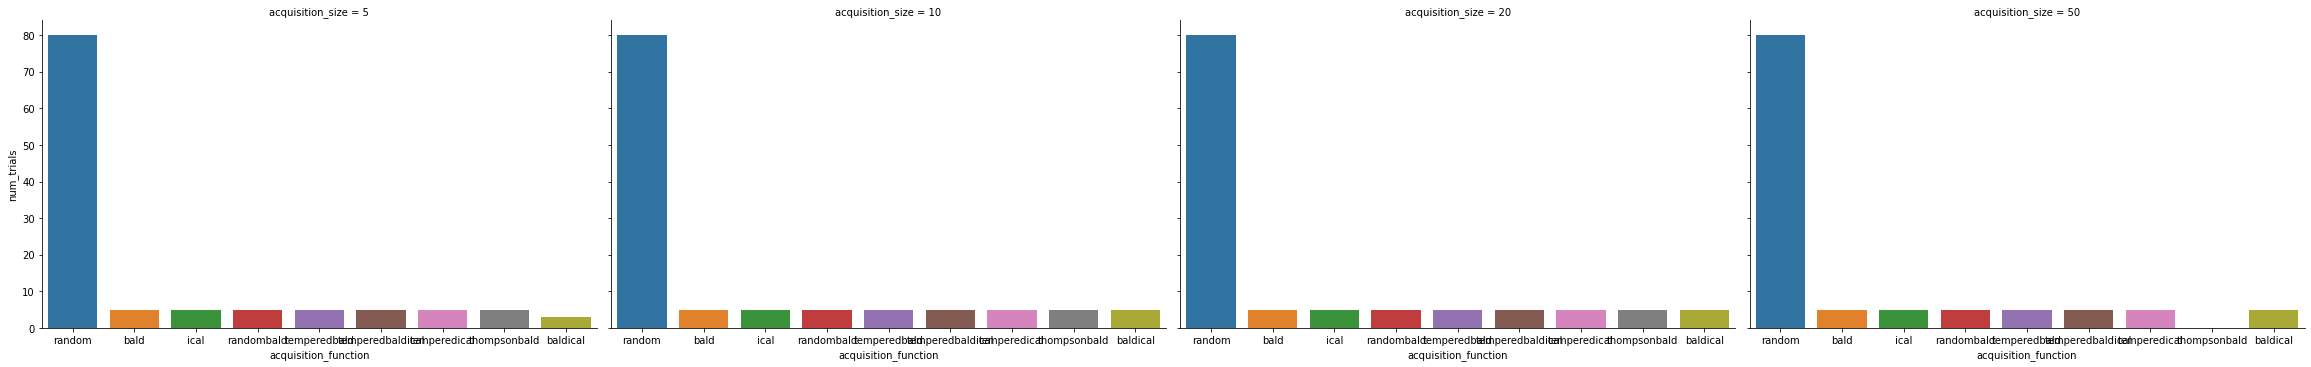

In [ ]:
grd = sns.catplot(
    data=num_trials_by_acquisition_size_and_function,
    kind="bar",
    y="num_trials",
    x="acquisition_function",
    col="acquisition_size",
    aspect=1.6,
)
grd.fig.patch.set_alpha(1)

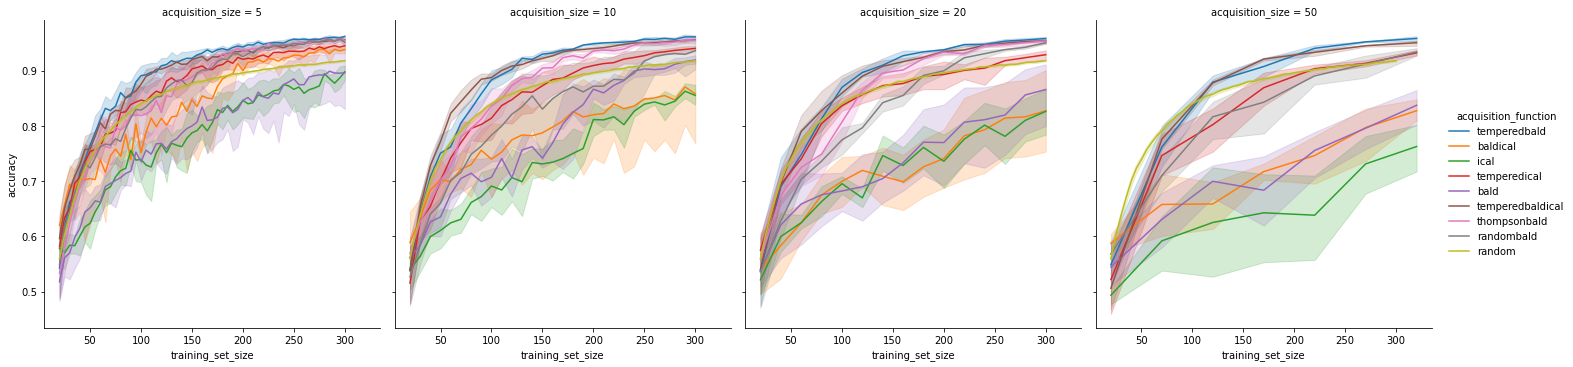

In [ ]:
grd = sns.relplot(
    x="training_set_size",
    y="accuracy",
    col="acquisition_size",
    hue="acquisition_function",
    data=df,
    kind="line",
    height=5,
)

grd.fig.patch.set_alpha(1)

In [ ]:
df2 = df[df.accuracy >= 0.90].groupby(["seed", "acquisition_size", "acquisition_function"]).first()

In [ ]:
df3 = df2.groupby(["acquisition_size", "acquisition_function"]).training_set_size.quantile([0.25,0.5,0.75])

In [ ]:
print(df3.unstack())

                                         0.25   0.50    0.75
acquisition_size acquisition_function                       
5                bald                  202.50  210.0  227.50
                 baldical              172.50  195.0  195.00
                 ical                  237.50  260.0  283.75
                 random                178.75  195.0  216.25
                 randombald            130.00  155.0  175.00
                 temperedbald          100.00  105.0  105.00
                 temperedbaldical      105.00  110.0  115.00
                 temperedical          130.00  145.0  160.00
                 thompsonbald          140.00  160.0  165.00
10               bald                  240.00  270.0  280.00
                 baldical              202.50  215.0  227.50
                 random                178.75  195.0  216.25
                 randombald            157.50  175.0  187.50
                 temperedbald          100.00  120.0  130.00
                 tempere